In [37]:
import json, os
from pprint import pprint
train_map = dict()
TRAIN_JSON = './annotations/train.json'
with open(TRAIN_JSON, 'r') as tr:
    train_map = json.load(tr)
    
categories = []
CAT_TXT = './annotations/categories.txt'
with open(CAT_TXT, 'r') as tr:
    categories = [x.strip('\n') for x in tr.readlines()]

In [27]:
categories

['sheep',
 'horse',
 'bicycle',
 'motorbike',
 'cow',
 'sofa',
 'aeroplane',
 'dog',
 'cat',
 'person',
 'train',
 'boat',
 'bottle',
 'bus',
 'pottedplant',
 'tvmonitor',
 'chair',
 'bird',
 'diningtable',
 'car']

In [33]:
# Cardinality
n = float(len(train_map))
label_cardinality = 0
for instance, active_labels in train_map.items():
    label_cardinality += len(active_labels)
    
label_cardinality /= n
    
label_cardinality

1.53947621798575

In [21]:
# Label Density
label_density = label_cardinality / len(categories)

label_density

0.07697381089930029

In [38]:
# IRLbl(y)
label_counts = []
for label in categories:
    l_count = 0
    for instance, active_labels in train_map.items():
        l_count += (1 if label in active_labels else 0)
    label_counts.append(l_count)
    
label_counts

max_label_count = float(max(label_counts))

IRLbls = []
for i in range(len(categories)):
    IRLbls.append(max_label_count/label_counts[i])
    
mean_IR = sum(IRLbls)/len(IRLbls)

pprint(IRLbls)
mean_IR

[13.513698630136986,
 9.071264367816092,
 7.722113502935421,
 8.186721991701244,
 14.34909090909091,
 6.2634920634920634,
 6.437194127243067,
 3.3784246575342465,
 4.063851699279094,
 1.0,
 7.87624750499002,
 8.653508771929825,
 5.777452415812592,
 10.170103092783505,
 7.662135922330097,
 7.240366972477064,
 3.327150084317032,
 5.702312138728324,
 6.745299145299145,
 3.5390134529147983]


7.033972072540576

In [50]:
a = [1,2,3, 4]
print reduce(lambda x,y:x*y , a)

24


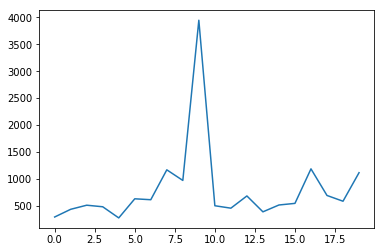

In [39]:
from matplotlib import pyplot as plt
plt.plot(label_counts)
plt.show()

In [59]:
# SCUMBLE

scumbles = []
for instance, active_labels in train_map.items():
    get_IRLbl = lambda x: IRLbls[categories.index(x)]
    IRLbli = map(get_IRLbl, active_labels) 
    
    IRLbli_bar = sum(IRLbli)/len(IRLbli)
    IRLbli_prod = (reduce(lambda x,y:x*y, IRLbli))
    
    scumblei = 1 - (IRLbli_prod ** (1/len(categories))) / IRLbli_bar
    scumbles.append(scumblei)

SCUMBLE = sum(scumbles)/len(scumbles)
SCUMBLE

0.7172507211963516

In [103]:
import random
random.randint(1, 10)

10

In [146]:
import random
from collections import defaultdict
class Sampler():
    def __init__(self, data, categories):
        self.D = data
        self.L = categories
        
        # Calculate imbalance levels
        self.IRLbl_l, self.IRMean = self.calculate_IRs(self.D, self.L)
        
    def calculate_IRs(self, D, L):
        # IRLbl(y)
        label_counts = [0]*len(L)
        for instance, active_labels in D:
            for l in active_labels:
                l_index = L.index(l)
                label_counts[l_index] += 1

        max_label_count = float(max(label_counts))

        IRLbl_l = []
        for i in range(len(L)):
            IRLbl_l.append(max_label_count/label_counts[i])

        IRMean = sum(IRLbls)/len(IRLbls)

        return IRLbl_l, IRMean 
    
    def calculate_SCUMBLES(self):
        # SCUMBLE
        scumbles = []
        for instance, active_labels in self.D:
            IRLbli = map(self.get_IRLbl, active_labels) 
            IRLbli_bar = sum(IRLbli)/len(IRLbli)
            IRLbli_prod = (reduce(lambda x,y:x*y, IRLbli))

            scumblei = 1 - (IRLbli_prod ** (1/len(self.L))) / IRLbli_bar
            scumbles.append(scumblei)

        SCUMBLE = sum(scumbles)/len(scumbles)
        return scumbles, SCUMBLE

    def get_IRLbl(self, x): 
        return self.IRLbl_l[self.L.index(x)] 
    
    def REMEDIAL(self):
        # Calculate SCUMBLE
        SCUMBLE_ins, SCUMBLE = self.calculate_SCUMBLES()
        
        # Edit dataset
        new_D = self.D[:] # copy dataset
        for i in range(len(new_D)):
            if SCUMBLE_ins[i] > SCUMBLE:
                instance, labels = new_D[i]
                # Maintain minority labels
                min_labels = filter(lambda x: self.get_IRLbl(x) > self.IRMean, labels)
                maj_labels = filter(lambda x: self.get_IRLbl(x) <= self.IRMean, labels)

                new_D[i] = (instance, min_labels)
                Di = (instance, maj_labels)
                new_D.append(Di)

        return new_D

    
    def ML_ROS(self, P):
        label_to_instance_map = defaultdict(list)
        for instance, labels in self.D:
            for l in labels:
                label_to_instance_map[l].append((instance, labels))
        
        num_samples_to_clone = int(len(self.D)*(P/(100.)))
        print num_samples_to_clone
        
        min_bags = {
            l:ins for l,ins in label_to_instance_map.items()
            if self.get_IRLbl(l) > self.IRMean
        }
        
        new_D = self.D
        while num_samples_to_clone > 0:
            # Clone a random sample from each minority bag
            labels_to_remove = []
            for l in min_bags:
                instance_to_clone = random.choice(min_bags[l])
                new_D.append(instance_to_clone)
                
                new_IRs, _ = self.calculate_IRs(new_D, self.L)
                new_IR_l = new_IRs[self.L.index(l)]

                if new_IR_l <= self.IRMean:
                    # Exclude from cloning
                    labels_to_remove.append(l)
                    
                num_samples_to_clone -= 1
      
            for l in labels_to_remove:
                del min_bags[l]
            
            if len(min_bags.keys()) == 0:
                print("Unable to clone all samples. {} left to clone".format(num_samples_to_clone))
                break
                
        return new_D
    
    
    def LP_ROS(P):
        

In [147]:
sampler = Sampler(train_map.items(), categories)


In [148]:
r = sampler.ML_ROS(10)

1038


In [149]:
hybrid_sampler = Sampler(r, categories)

In [150]:
h = hybrid_sampler.REMEDIAL()

In [164]:
a = sorted(map(lambda x: [os.path.basename(x[0]), x[1]], h), key=lambda x: x[0])
b = filter(lambda x: x[1]!=[], a)
pprint(b)

[[u'2008_000002.jpg', [u'tvmonitor']],
 [u'2008_000003.jpg', [u'train']],
 [u'2008_000003.jpg', [u'person']],
 [u'2008_000007.jpg', [u'boat']],
 [u'2008_000008.jpg', [u'horse']],
 [u'2008_000008.jpg', [u'horse']],
 [u'2008_000008.jpg', [u'person']],
 [u'2008_000008.jpg', [u'person']],
 [u'2008_000015.jpg', [u'bottle']],
 [u'2008_000016.jpg', [u'tvmonitor']],
 [u'2008_000019.jpg', [u'dog']],
 [u'2008_000021.jpg', [u'aeroplane']],
 [u'2008_000023.jpg', [u'tvmonitor']],
 [u'2008_000023.jpg', [u'bottle', u'person']],
 [u'2008_000026.jpg', [u'person', u'dog']],
 [u'2008_000027.jpg', [u'car']],
 [u'2008_000028.jpg', [u'car']],
 [u'2008_000032.jpg', [u'bus']],
 [u'2008_000032.jpg', [u'bus']],
 [u'2008_000032.jpg', [u'person']],
 [u'2008_000032.jpg', [u'person']],
 [u'2008_000033.jpg', [u'aeroplane']],
 [u'2008_000034.jpg', [u'bottle', u'person']],
 [u'2008_000036.jpg', [u'bicycle', u'boat']],
 [u'2008_000036.jpg', [u'person']],
 [u'2008_000037.jpg', [u'aeroplane']],
 [u'2008_000041.jpg', [u'd

 [u'2008_000615.jpg', [u'bicycle']],
 [u'2008_000615.jpg', [u'person']],
 [u'2008_000619.jpg', [u'cat', u'car']],
 [u'2008_000620.jpg', [u'person', u'dog']],
 [u'2008_000622.jpg', [u'person']],
 [u'2008_000623.jpg', [u'person']],
 [u'2008_000626.jpg', [u'chair']],
 [u'2008_000628.jpg', [u'person']],
 [u'2008_000629.jpg', [u'person']],
 [u'2008_000630.jpg', [u'person']],
 [u'2008_000634.jpg', [u'person']],
 [u'2008_000636.jpg', [u'person', u'sofa']],
 [u'2008_000640.jpg', [u'person']],
 [u'2008_000641.jpg', [u'cat', u'dog']],
 [u'2008_000645.jpg', [u'person']],
 [u'2008_000646.jpg', [u'person']],
 [u'2008_000647.jpg', [u'person']],
 [u'2008_000648.jpg', [u'person', u'sofa', u'bottle']],
 [u'2008_000650.jpg', [u'person']],
 [u'2008_000652.jpg', [u'person']],
 [u'2008_000656.jpg', [u'person']],
 [u'2008_000657.jpg', [u'train']],
 [u'2008_000660.jpg', [u'person', u'cat']],
 [u'2008_000661.jpg', [u'person', u'dog']],
 [u'2008_000662.jpg', [u'person']],
 [u'2008_000666.jpg', [u'person']],
 [

 [u'2008_001681.jpg', [u'bus']],
 [u'2008_001681.jpg', [u'car', u'person']],
 [u'2008_001682.jpg', [u'horse']],
 [u'2008_001688.jpg', [u'tvmonitor', u'pottedplant']],
 [u'2008_001690.jpg', [u'motorbike']],
 [u'2008_001690.jpg', [u'person']],
 [u'2008_001691.jpg', [u'motorbike']],
 [u'2008_001692.jpg', [u'person']],
 [u'2008_001694.jpg', [u'pottedplant']],
 [u'2008_001694.jpg', [u'chair', u'sofa']],
 [u'2008_001697.jpg', [u'person']],
 [u'2008_001699.jpg', [u'motorbike']],
 [u'2008_001699.jpg', [u'motorbike']],
 [u'2008_001699.jpg', [u'person']],
 [u'2008_001699.jpg', [u'person']],
 [u'2008_001702.jpg', [u'chair', u'person']],
 [u'2008_001704.jpg', [u'tvmonitor']],
 [u'2008_001706.jpg', [u'person', u'bottle']],
 [u'2008_001708.jpg', [u'cat', u'dog']],
 [u'2008_001709.jpg', [u'person']],
 [u'2008_001710.jpg', [u'train']],
 [u'2008_001710.jpg', [u'person']],
 [u'2008_001712.jpg', [u'person']],
 [u'2008_001714.jpg', [u'person']],
 [u'2008_001715.jpg', [u'chair']],
 [u'2008_001716.jpg', [u'

 [u'2008_002509.jpg', [u'horse']],
 [u'2008_002510.jpg', [u'person']],
 [u'2008_002512.jpg', [u'person']],
 [u'2008_002515.jpg', [u'bicycle']],
 [u'2008_002515.jpg', [u'person']],
 [u'2008_002516.jpg', [u'car']],
 [u'2008_002521.jpg', [u'chair']],
 [u'2008_002523.jpg', [u'person']],
 [u'2008_002524.jpg', [u'person', u'car']],
 [u'2008_002526.jpg', [u'person']],
 [u'2008_002527.jpg', [u'person']],
 [u'2008_002533.jpg', [u'person', u'sofa']],
 [u'2008_002536.jpg', [u'sheep']],
 [u'2008_002536.jpg', [u'dog']],
 [u'2008_002540.jpg', [u'person']],
 [u'2008_002542.jpg', [u'person']],
 [u'2008_002543.jpg', [u'person']],
 [u'2008_002547.jpg', [u'tvmonitor']],
 [u'2008_002549.jpg', [u'person']],
 [u'2008_002551.jpg', [u'aeroplane']],
 [u'2008_002555.jpg', [u'person', u'car']],
 [u'2008_002558.jpg', [u'person']],
 [u'2008_002562.jpg', [u'person']],
 [u'2008_002564.jpg', [u'diningtable']],
 [u'2008_002564.jpg', [u'person']],
 [u'2008_002566.jpg', [u'person']],
 [u'2008_002567.jpg', [u'diningtable

 [u'2008_003476.jpg', [u'person']],
 [u'2008_003477.jpg', [u'diningtable']],
 [u'2008_003477.jpg', [u'chair']],
 [u'2008_003478.jpg', [u'aeroplane', u'person']],
 [u'2008_003479.jpg', [u'motorbike']],
 [u'2008_003479.jpg', [u'car', u'person']],
 [u'2008_003480.jpg', [u'boat']],
 [u'2008_003480.jpg', [u'boat']],
 [u'2008_003480.jpg', [u'boat']],
 [u'2008_003482.jpg', [u'person']],
 [u'2008_003484.jpg', [u'bird']],
 [u'2008_003485.jpg', [u'bird']],
 [u'2008_003488.jpg', [u'person']],
 [u'2008_003489.jpg', [u'bus']],
 [u'2008_003489.jpg', [u'car']],
 [u'2008_003492.jpg', [u'person']],
 [u'2008_003493.jpg', [u'person']],
 [u'2008_003496.jpg', [u'person', u'sofa']],
 [u'2008_003498.jpg', [u'motorbike']],
 [u'2008_003498.jpg', [u'car']],
 [u'2008_003499.jpg', [u'cat']],
 [u'2008_003500.jpg', [u'tvmonitor']],
 [u'2008_003501.jpg', [u'cat', u'chair']],
 [u'2008_003504.jpg', [u'chair', u'person']],
 [u'2008_003507.jpg', [u'person']],
 [u'2008_003510.jpg', [u'person']],
 [u'2008_003511.jpg', [u'

 [u'2008_004292.jpg', [u'sheep']],
 [u'2008_004293.jpg', [u'diningtable']],
 [u'2008_004293.jpg', [u'dog']],
 [u'2008_004296.jpg', [u'bird']],
 [u'2008_004297.jpg', [u'tvmonitor']],
 [u'2008_004297.jpg', [u'dog', u'chair']],
 [u'2008_004303.jpg', [u'cat']],
 [u'2008_004306.jpg', [u'dog']],
 [u'2008_004307.jpg', [u'person', u'car']],
 [u'2008_004308.jpg', [u'diningtable']],
 [u'2008_004308.jpg', [u'bottle', u'person']],
 [u'2008_004312.jpg', [u'car']],
 [u'2008_004313.jpg', [u'chair']],
 [u'2008_004317.jpg', [u'bird']],
 [u'2008_004319.jpg', [u'dog']],
 [u'2008_004321.jpg', [u'diningtable', u'tvmonitor']],
 [u'2008_004321.jpg', [u'person', u'chair', u'sofa']],
 [u'2008_004324.jpg', [u'dog']],
 [u'2008_004325.jpg', [u'bicycle']],
 [u'2008_004325.jpg', [u'bicycle']],
 [u'2008_004325.jpg', [u'person']],
 [u'2008_004325.jpg', [u'person']],
 [u'2008_004326.jpg', [u'car']],
 [u'2008_004327.jpg', [u'person']],
 [u'2008_004328.jpg', [u'pottedplant']],
 [u'2008_004328.jpg', [u'cat', u'person']],

 [u'2008_005089.jpg', [u'tvmonitor']],
 [u'2008_005089.jpg', [u'person', u'bottle']],
 [u'2008_005089.jpg', [u'person', u'bottle']],
 [u'2008_005090.jpg', [u'tvmonitor']],
 [u'2008_005090.jpg', [u'bottle', u'person', u'sofa']],
 [u'2008_005092.jpg', [u'bird']],
 [u'2008_005094.jpg', [u'tvmonitor']],
 [u'2008_005094.jpg', [u'person', u'bottle']],
 [u'2008_005096.jpg', [u'bird']],
 [u'2008_005097.jpg', [u'cow']],
 [u'2008_005097.jpg', [u'cow']],
 [u'2008_005097.jpg', [u'cow']],
 [u'2008_005101.jpg', [u'dog', u'person', u'car']],
 [u'2008_005105.jpg', [u'cow']],
 [u'2008_005105.jpg', [u'cow']],
 [u'2008_005107.jpg', [u'person', u'chair']],
 [u'2008_005108.jpg', [u'boat']],
 [u'2008_005109.jpg', [u'cat']],
 [u'2008_005110.jpg', [u'car', u'person']],
 [u'2008_005111.jpg', [u'pottedplant']],
 [u'2008_005111.jpg', [u'dog', u'chair', u'person']],
 [u'2008_005114.jpg', [u'aeroplane']],
 [u'2008_005115.jpg', [u'bird']],
 [u'2008_005117.jpg', [u'boat']],
 [u'2008_005123.jpg', [u'dog']],
 [u'2008_

 [u'2008_005976.jpg', [u'boat', u'tvmonitor']],
 [u'2008_005976.jpg', [u'boat', u'tvmonitor']],
 [u'2008_005976.jpg', [u'person']],
 [u'2008_005976.jpg', [u'person']],
 [u'2008_005977.jpg', [u'cat']],
 [u'2008_005978.jpg', [u'bicycle']],
 [u'2008_005978.jpg', [u'person']],
 [u'2008_005979.jpg', [u'sofa', u'dog', u'cat']],
 [u'2008_005980.jpg', [u'dog']],
 [u'2008_005982.jpg', [u'bicycle']],
 [u'2008_005984.jpg', [u'bus']],
 [u'2008_005984.jpg', [u'person', u'car']],
 [u'2008_005987.jpg', [u'sheep']],
 [u'2008_005989.jpg', [u'car']],
 [u'2008_005991.jpg', [u'bottle', u'person']],
 [u'2008_005997.jpg', [u'bird']],
 [u'2008_006000.jpg', [u'bird']],
 [u'2008_006002.jpg', [u'bird']],
 [u'2008_006007.jpg', [u'dog', u'person']],
 [u'2008_006010.jpg', [u'train']],
 [u'2008_006014.jpg', [u'boat']],
 [u'2008_006014.jpg', [u'person']],
 [u'2008_006017.jpg', [u'motorbike']],
 [u'2008_006017.jpg', [u'car']],
 [u'2008_006020.jpg', [u'dog']],
 [u'2008_006024.jpg', [u'person', u'bottle']],
 [u'2008_00

 [u'2008_006779.jpg', [u'horse']],
 [u'2008_006779.jpg', [u'person']],
 [u'2008_006779.jpg', [u'person']],
 [u'2008_006781.jpg', [u'cat']],
 [u'2008_006784.jpg', [u'sofa']],
 [u'2008_006785.jpg', [u'cat']],
 [u'2008_006792.jpg', [u'bottle', u'chair']],
 [u'2008_006793.jpg', [u'cat']],
 [u'2008_006797.jpg', [u'horse']],
 [u'2008_006798.jpg', [u'dog', u'person']],
 [u'2008_006800.jpg', [u'car', u'person']],
 [u'2008_006802.jpg', [u'bird']],
 [u'2008_006807.jpg', [u'bicycle', u'pottedplant']],
 [u'2008_006807.jpg', [u'bicycle', u'pottedplant']],
 [u'2008_006807.jpg', [u'bicycle', u'pottedplant']],
 [u'2008_006807.jpg', [u'person']],
 [u'2008_006807.jpg', [u'person']],
 [u'2008_006807.jpg', [u'person']],
 [u'2008_006808.jpg', [u'diningtable']],
 [u'2008_006808.jpg', [u'chair', u'dog', u'bottle']],
 [u'2008_006810.jpg', [u'cat']],
 [u'2008_006811.jpg', [u'dog']],
 [u'2008_006813.jpg', [u'bicycle']],
 [u'2008_006813.jpg', [u'person']],
 [u'2008_006815.jpg', [u'bottle']],
 [u'2008_006816.jpg'

 [u'2008_007745.jpg', [u'dog', u'person']],
 [u'2008_007748.jpg', [u'boat']],
 [u'2008_007748.jpg', [u'boat']],
 [u'2008_007749.jpg', [u'train']],
 [u'2008_007749.jpg', [u'train']],
 [u'2008_007750.jpg', [u'boat']],
 [u'2008_007752.jpg', [u'bird']],
 [u'2008_007755.jpg', [u'boat']],
 [u'2008_007757.jpg', [u'person', u'car']],
 [u'2008_007758.jpg', [u'aeroplane']],
 [u'2008_007759.jpg', [u'train']],
 [u'2008_007759.jpg', [u'person']],
 [u'2008_007760.jpg', [u'train']],
 [u'2008_007760.jpg', [u'train']],
 [u'2008_007761.jpg', [u'bicycle']],
 [u'2008_007761.jpg', [u'person']],
 [u'2008_007764.jpg', [u'aeroplane']],
 [u'2008_007766.jpg', [u'bicycle']],
 [u'2008_007766.jpg', [u'person']],
 [u'2008_007768.jpg', [u'person', u'chair']],
 [u'2008_007770.jpg', [u'person', u'dog']],
 [u'2008_007777.jpg', [u'cat']],
 [u'2008_007779.jpg', [u'train']],
 [u'2008_007779.jpg', [u'train']],
 [u'2008_007779.jpg', [u'person']],
 [u'2008_007779.jpg', [u'person']],
 [u'2008_007780.jpg', [u'chair']],
 [u'200

 [u'2008_008681.jpg', [u'train']],
 [u'2008_008681.jpg', [u'train']],
 [u'2008_008681.jpg', [u'car']],
 [u'2008_008681.jpg', [u'car']],
 [u'2008_008682.jpg', [u'bus']],
 [u'2008_008683.jpg', [u'bus']],
 [u'2008_008683.jpg', [u'person']],
 [u'2008_008684.jpg', [u'bus']],
 [u'2008_008684.jpg', [u'person']],
 [u'2008_008685.jpg', [u'cow']],
 [u'2008_008689.jpg', [u'pottedplant']],
 [u'2008_008691.jpg', [u'bicycle']],
 [u'2008_008691.jpg', [u'person']],
 [u'2008_008694.jpg', [u'chair', u'bottle']],
 [u'2008_008695.jpg', [u'bicycle']],
 [u'2008_008695.jpg', [u'person']],
 [u'2008_008696.jpg', [u'train']],
 [u'2008_008697.jpg', [u'train']],
 [u'2008_008697.jpg', [u'person']],
 [u'2008_008700.jpg', [u'bottle']],
 [u'2008_008701.jpg', [u'bus']],
 [u'2008_008701.jpg', [u'bus']],
 [u'2008_008701.jpg', [u'person', u'car']],
 [u'2008_008701.jpg', [u'person', u'car']],
 [u'2008_008705.jpg', [u'bus', u'bicycle']],
 [u'2008_008705.jpg', [u'bus', u'bicycle']],
 [u'2008_008705.jpg', [u'person']],
 [u'2

 [u'2009_000694.jpg', [u'cow']],
 [u'2009_000695.jpg', [u'aeroplane']],
 [u'2009_000696.jpg', [u'bicycle']],
 [u'2009_000702.jpg', [u'dog']],
 [u'2009_000705.jpg', [u'horse']],
 [u'2009_000705.jpg', [u'horse']],
 [u'2009_000708.jpg', [u'bus']],
 [u'2009_000708.jpg', [u'car']],
 [u'2009_000709.jpg', [u'cow']],
 [u'2009_000712.jpg', [u'train']],
 [u'2009_000716.jpg', [u'cat']],
 [u'2009_000718.jpg', [u'bottle', u'dog']],
 [u'2009_000719.jpg', [u'motorbike']],
 [u'2009_000719.jpg', [u'person']],
 [u'2009_000720.jpg', [u'car']],
 [u'2009_000722.jpg', [u'tvmonitor', u'pottedplant']],
 [u'2009_000722.jpg', [u'chair']],
 [u'2009_000723.jpg', [u'boat']],
 [u'2009_000724.jpg', [u'bicycle']],
 [u'2009_000724.jpg', [u'bicycle']],
 [u'2009_000724.jpg', [u'person']],
 [u'2009_000724.jpg', [u'person']],
 [u'2009_000725.jpg', [u'sheep']],
 [u'2009_000726.jpg', [u'motorbike']],
 [u'2009_000726.jpg', [u'car', u'person']],
 [u'2009_000727.jpg', [u'horse']],
 [u'2009_000727.jpg', [u'person']],
 [u'2009_0

 [u'2009_001537.jpg', [u'sheep']],
 [u'2009_001539.jpg', [u'horse']],
 [u'2009_001539.jpg', [u'person']],
 [u'2009_001541.jpg', [u'aeroplane']],
 [u'2009_001542.jpg', [u'motorbike']],
 [u'2009_001542.jpg', [u'motorbike']],
 [u'2009_001544.jpg', [u'boat']],
 [u'2009_001546.jpg', [u'car', u'person']],
 [u'2009_001549.jpg', [u'aeroplane']],
 [u'2009_001550.jpg', [u'cat']],
 [u'2009_001553.jpg', [u'tvmonitor']],
 [u'2009_001553.jpg', [u'person', u'dog']],
 [u'2009_001554.jpg', [u'bird']],
 [u'2009_001555.jpg', [u'tvmonitor']],
 [u'2009_001558.jpg', [u'bicycle']],
 [u'2009_001562.jpg', [u'cat']],
 [u'2009_001565.jpg', [u'bird']],
 [u'2009_001566.jpg', [u'motorbike']],
 [u'2009_001566.jpg', [u'motorbike']],
 [u'2009_001566.jpg', [u'person']],
 [u'2009_001566.jpg', [u'person']],
 [u'2009_001567.jpg', [u'boat']],
 [u'2009_001567.jpg', [u'boat']],
 [u'2009_001568.jpg', [u'dog']],
 [u'2009_001575.jpg', [u'diningtable']],
 [u'2009_001575.jpg', [u'person', u'chair']],
 [u'2009_001577.jpg', [u'sofa

 [u'2009_002476.jpg', [u'dog']],
 [u'2009_002477.jpg', [u'horse']],
 [u'2009_002477.jpg', [u'horse']],
 [u'2009_002477.jpg', [u'person']],
 [u'2009_002477.jpg', [u'person']],
 [u'2009_002488.jpg', [u'bicycle']],
 [u'2009_002499.jpg', [u'cat']],
 [u'2009_002500.jpg', [u'dog', u'person']],
 [u'2009_002504.jpg', [u'cat', u'person']],
 [u'2009_002505.jpg', [u'bus']],
 [u'2009_002505.jpg', [u'car']],
 [u'2009_002506.jpg', [u'boat']],
 [u'2009_002506.jpg', [u'person']],
 [u'2009_002510.jpg', [u'cow']],
 [u'2009_002512.jpg', [u'bus']],
 [u'2009_002512.jpg', [u'person']],
 [u'2009_002514.jpg', [u'person']],
 [u'2009_002515.jpg', [u'horse']],
 [u'2009_002518.jpg', [u'cow']],
 [u'2009_002521.jpg', [u'bottle']],
 [u'2009_002522.jpg', [u'person', u'dog', u'sofa']],
 [u'2009_002523.jpg', [u'chair', u'sofa']],
 [u'2009_002525.jpg', [u'bird']],
 [u'2009_002530.jpg', [u'boat']],
 [u'2009_002530.jpg', [u'boat']],
 [u'2009_002531.jpg', [u'aeroplane']],
 [u'2009_002532.jpg', [u'bus']],
 [u'2009_002532.jp

 [u'2009_003445.jpg', [u'horse']],
 [u'2009_003447.jpg', [u'bus']],
 [u'2009_003447.jpg', [u'car', u'person']],
 [u'2009_003450.jpg', [u'bird']],
 [u'2009_003453.jpg', [u'train']],
 [u'2009_003453.jpg', [u'train']],
 [u'2009_003453.jpg', [u'person']],
 [u'2009_003453.jpg', [u'person']],
 [u'2009_003454.jpg', [u'person']],
 [u'2009_003455.jpg', [u'cow']],
 [u'2009_003456.jpg', [u'aeroplane']],
 [u'2009_003457.jpg', [u'cat']],
 [u'2009_003458.jpg', [u'bus']],
 [u'2009_003459.jpg', [u'pottedplant']],
 [u'2009_003459.jpg', [u'sofa', u'person']],
 [u'2009_003460.jpg', [u'sheep']],
 [u'2009_003461.jpg', [u'bus']],
 [u'2009_003462.jpg', [u'boat']],
 [u'2009_003462.jpg', [u'person']],
 [u'2009_003466.jpg', [u'dog']],
 [u'2009_003467.jpg', [u'dog']],
 [u'2009_003468.jpg', [u'diningtable']],
 [u'2009_003468.jpg', [u'person', u'bottle']],
 [u'2009_003469.jpg', [u'bicycle']],
 [u'2009_003476.jpg', [u'pottedplant']],
 [u'2009_003481.jpg', [u'horse']],
 [u'2009_003487.jpg', [u'bird']],
 [u'2009_0034

 [u'2009_004377.jpg', [u'person', u'chair']],
 [u'2009_004382.jpg', [u'cat']],
 [u'2009_004383.jpg', [u'bus']],
 [u'2009_004390.jpg', [u'dog']],
 [u'2009_004392.jpg', [u'dog']],
 [u'2009_004394.jpg', [u'pottedplant', u'diningtable']],
 [u'2009_004394.jpg', [u'bottle', u'cat']],
 [u'2009_004397.jpg', [u'boat']],
 [u'2009_004399.jpg', [u'diningtable']],
 [u'2009_004402.jpg', [u'aeroplane']],
 [u'2009_004403.jpg', [u'dog', u'person']],
 [u'2009_004404.jpg', [u'pottedplant']],
 [u'2009_004404.jpg', [u'chair']],
 [u'2009_004406.jpg', [u'train']],
 [u'2009_004406.jpg', [u'train']],
 [u'2009_004406.jpg', [u'person']],
 [u'2009_004406.jpg', [u'person']],
 [u'2009_004409.jpg', [u'aeroplane']],
 [u'2009_004410.jpg', [u'person']],
 [u'2009_004411.jpg', [u'dog']],
 [u'2009_004414.jpg', [u'aeroplane']],
 [u'2009_004417.jpg', [u'bus']],
 [u'2009_004419.jpg', [u'diningtable']],
 [u'2009_004419.jpg', [u'chair', u'sofa']],
 [u'2009_004424.jpg', [u'cat']],
 [u'2009_004425.jpg', [u'dog']],
 [u'2009_00442

 [u'2009_005095.jpg', [u'cat']],
 [u'2009_005098.jpg', [u'bicycle']],
 [u'2009_005098.jpg', [u'bicycle']],
 [u'2009_005098.jpg', [u'bicycle']],
 [u'2009_005098.jpg', [u'person']],
 [u'2009_005098.jpg', [u'person']],
 [u'2009_005098.jpg', [u'person']],
 [u'2009_005102.jpg', [u'dog']],
 [u'2009_005103.jpg', [u'bicycle']],
 [u'2009_005103.jpg', [u'person']],
 [u'2009_005107.jpg', [u'dog']],
 [u'2009_005111.jpg', [u'aeroplane']],
 [u'2009_005114.jpg', [u'bird']],
 [u'2009_005118.jpg', [u'boat']],
 [u'2009_005119.jpg', [u'cat']],
 [u'2009_005120.jpg', [u'aeroplane']],
 [u'2009_005126.jpg', [u'train']],
 [u'2009_005127.jpg', [u'aeroplane']],
 [u'2009_005128.jpg', [u'train']],
 [u'2009_005129.jpg', [u'boat']],
 [u'2009_005129.jpg', [u'boat']],
 [u'2009_005130.jpg', [u'horse']],
 [u'2009_005131.jpg', [u'bird']],
 [u'2009_005133.jpg', [u'car']],
 [u'2009_005137.jpg', [u'bird']],
 [u'2009_005140.jpg', [u'person']],
 [u'2009_005141.jpg', [u'person']],
 [u'2009_005142.jpg', [u'aeroplane']],
 [u'20

 [u'2010_000639.jpg', [u'dog', u'chair']],
 [u'2010_000641.jpg', [u'sheep']],
 [u'2010_000641.jpg', [u'sheep']],
 [u'2010_000641.jpg', [u'sheep']],
 [u'2010_000644.jpg', [u'dog']],
 [u'2010_000645.jpg', [u'person', u'car']],
 [u'2010_000646.jpg', [u'chair']],
 [u'2010_000647.jpg', [u'cat', u'person']],
 [u'2010_000648.jpg', [u'dog', u'person']],
 [u'2010_000658.jpg', [u'tvmonitor']],
 [u'2010_000658.jpg', [u'chair', u'sofa']],
 [u'2010_000661.jpg', [u'cat']],
 [u'2010_000664.jpg', [u'car']],
 [u'2010_000665.jpg', [u'cat']],
 [u'2010_000667.jpg', [u'sheep']],
 [u'2010_000667.jpg', [u'sheep']],
 [u'2010_000669.jpg', [u'diningtable', u'tvmonitor', u'pottedplant']],
 [u'2010_000669.jpg', [u'chair']],
 [u'2010_000671.jpg', [u'bottle', u'sofa', u'person']],
 [u'2010_000674.jpg', [u'tvmonitor']],
 [u'2010_000674.jpg', [u'chair']],
 [u'2010_000675.jpg', [u'cat']],
 [u'2010_000678.jpg', [u'motorbike']],
 [u'2010_000679.jpg', [u'boat']],
 [u'2010_000679.jpg', [u'person']],
 [u'2010_000681.jpg', 

 [u'2010_001257.jpg', [u'sheep']],
 [u'2010_001261.jpg', [u'diningtable']],
 [u'2010_001261.jpg', [u'chair']],
 [u'2010_001263.jpg', [u'dog', u'person']],
 [u'2010_001264.jpg', [u'dog']],
 [u'2010_001270.jpg', [u'tvmonitor']],
 [u'2010_001270.jpg', [u'person']],
 [u'2010_001272.jpg', [u'train']],
 [u'2010_001272.jpg', [u'train']],
 [u'2010_001272.jpg', [u'train']],
 [u'2010_001272.jpg', [u'car', u'person']],
 [u'2010_001272.jpg', [u'car', u'person']],
 [u'2010_001272.jpg', [u'car', u'person']],
 [u'2010_001273.jpg', [u'dog']],
 [u'2010_001274.jpg', [u'car']],
 [u'2010_001275.jpg', [u'car']],
 [u'2010_001277.jpg', [u'tvmonitor']],
 [u'2010_001277.jpg', [u'sofa', u'chair']],
 [u'2010_001279.jpg', [u'dog']],
 [u'2010_001282.jpg', [u'dog']],
 [u'2010_001286.jpg', [u'sheep']],
 [u'2010_001287.jpg', [u'diningtable']],
 [u'2010_001287.jpg', [u'sofa', u'person']],
 [u'2010_001289.jpg', [u'boat']],
 [u'2010_001289.jpg', [u'person']],
 [u'2010_001291.jpg', [u'cat']],
 [u'2010_001293.jpg', [u'dog

 [u'2010_002245.jpg', [u'tvmonitor']],
 [u'2010_002245.jpg', [u'person']],
 [u'2010_002247.jpg', [u'tvmonitor']],
 [u'2010_002247.jpg', [u'person']],
 [u'2010_002248.jpg', [u'dog']],
 [u'2010_002251.jpg', [u'motorbike']],
 [u'2010_002251.jpg', [u'person']],
 [u'2010_002254.jpg', [u'cow']],
 [u'2010_002254.jpg', [u'cow']],
 [u'2010_002255.jpg', [u'cat', u'person']],
 [u'2010_002261.jpg', [u'train']],
 [u'2010_002267.jpg', [u'bird']],
 [u'2010_002269.jpg', [u'diningtable']],
 [u'2010_002269.jpg', [u'person', u'bottle', u'chair']],
 [u'2010_002271.jpg', [u'motorbike']],
 [u'2010_002274.jpg', [u'diningtable']],
 [u'2010_002274.jpg', [u'person', u'bottle']],
 [u'2010_002276.jpg', [u'dog', u'person']],
 [u'2010_002278.jpg', [u'cat', u'person']],
 [u'2010_002283.jpg', [u'horse']],
 [u'2010_002286.jpg', [u'cat']],
 [u'2010_002287.jpg', [u'dog', u'chair']],
 [u'2010_002294.jpg', [u'sheep']],
 [u'2010_002294.jpg', [u'sheep']],
 [u'2010_002295.jpg', [u'aeroplane']],
 [u'2010_002299.jpg', [u'dog']

 [u'2010_003051.jpg', [u'aeroplane']],
 [u'2010_003053.jpg', [u'aeroplane']],
 [u'2010_003054.jpg', [u'aeroplane', u'person']],
 [u'2010_003055.jpg', [u'dog', u'person']],
 [u'2010_003056.jpg', [u'dog', u'person']],
 [u'2010_003057.jpg', [u'bus']],
 [u'2010_003057.jpg', [u'car']],
 [u'2010_003060.jpg', [u'dog']],
 [u'2010_003062.jpg', [u'bicycle']],
 [u'2010_003062.jpg', [u'person']],
 [u'2010_003067.jpg', [u'cat']],
 [u'2010_003071.jpg', [u'dog']],
 [u'2010_003072.jpg', [u'dog', u'person']],
 [u'2010_003074.jpg', [u'sheep']],
 [u'2010_003074.jpg', [u'sheep']],
 [u'2010_003077.jpg', [u'dog']],
 [u'2010_003078.jpg', [u'diningtable']],
 [u'2010_003078.jpg', [u'person', u'chair']],
 [u'2010_003081.jpg', [u'bird']],
 [u'2010_003082.jpg', [u'dog']],
 [u'2010_003084.jpg', [u'diningtable']],
 [u'2010_003084.jpg', [u'chair', u'person']],
 [u'2010_003086.jpg', [u'dog']],
 [u'2010_003088.jpg', [u'aeroplane']],
 [u'2010_003091.jpg', [u'diningtable']],
 [u'2010_003091.jpg', [u'person', u'bottle']]

 [u'2010_003857.jpg', [u'tvmonitor']],
 [u'2010_003860.jpg', [u'boat']],
 [u'2010_003861.jpg', [u'pottedplant']],
 [u'2010_003861.jpg', [u'cat', u'chair', u'person', u'sofa']],
 [u'2010_003863.jpg', [u'cat']],
 [u'2010_003864.jpg', [u'tvmonitor', u'pottedplant', u'diningtable']],
 [u'2010_003864.jpg', [u'sofa', u'chair']],
 [u'2010_003865.jpg', [u'sheep']],
 [u'2010_003871.jpg', [u'person']],
 [u'2010_003875.jpg', [u'cat']],
 [u'2010_003877.jpg', [u'bus']],
 [u'2010_003877.jpg', [u'car', u'person']],
 [u'2010_003878.jpg', [u'boat']],
 [u'2010_003878.jpg', [u'person']],
 [u'2010_003879.jpg', [u'dog']],
 [u'2010_003884.jpg', [u'dog', u'person']],
 [u'2010_003887.jpg', [u'cat']],
 [u'2010_003890.jpg', [u'horse']],
 [u'2010_003891.jpg', [u'dog']],
 [u'2010_003892.jpg', [u'tvmonitor']],
 [u'2010_003892.jpg', [u'person']],
 [u'2010_003893.jpg', [u'bus']],
 [u'2010_003893.jpg', [u'car']],
 [u'2010_003894.jpg', [u'dog', u'person', u'chair']],
 [u'2010_003897.jpg', [u'diningtable']],
 [u'2010_0

 [u'2010_004460.jpg', [u'tvmonitor']],
 [u'2010_004460.jpg', [u'bottle']],
 [u'2010_004461.jpg', [u'dog']],
 [u'2010_004466.jpg', [u'pottedplant']],
 [u'2010_004467.jpg', [u'diningtable']],
 [u'2010_004467.jpg', [u'cat', u'chair']],
 [u'2010_004469.jpg', [u'train']],
 [u'2010_004469.jpg', [u'person']],
 [u'2010_004472.jpg', [u'car', u'person']],
 [u'2010_004475.jpg', [u'train']],
 [u'2010_004475.jpg', [u'person']],
 [u'2010_004476.jpg', [u'dog']],
 [u'2010_004477.jpg', [u'horse']],
 [u'2010_004478.jpg', [u'train']],
 [u'2010_004479.jpg', [u'tvmonitor']],
 [u'2010_004479.jpg', [u'person', u'cat']],
 [u'2010_004481.jpg', [u'sofa', u'person']],
 [u'2010_004483.jpg', [u'bird']],
 [u'2010_004484.jpg', [u'car']],
 [u'2010_004488.jpg', [u'bottle']],
 [u'2010_004491.jpg', [u'person']],
 [u'2010_004493.jpg', [u'boat']],
 [u'2010_004493.jpg', [u'dog']],
 [u'2010_004499.jpg', [u'sheep']],
 [u'2010_004499.jpg', [u'sheep']],
 [u'2010_004499.jpg', [u'person']],
 [u'2010_004499.jpg', [u'person']],
 [

 [u'2010_005297.jpg', [u'cow']],
 [u'2010_005299.jpg', [u'bottle', u'person']],
 [u'2010_005301.jpg', [u'aeroplane']],
 [u'2010_005303.jpg', [u'person']],
 [u'2010_005305.jpg', [u'tvmonitor', u'pottedplant']],
 [u'2010_005306.jpg', [u'dog', u'person']],
 [u'2010_005308.jpg', [u'chair']],
 [u'2010_005309.jpg', [u'train']],
 [u'2010_005310.jpg', [u'sheep']],
 [u'2010_005312.jpg', [u'dog', u'cat']],
 [u'2010_005314.jpg', [u'person']],
 [u'2010_005318.jpg', [u'car', u'person', u'chair']],
 [u'2010_005320.jpg', [u'bird']],
 [u'2010_005323.jpg', [u'car']],
 [u'2010_005327.jpg', [u'person']],
 [u'2010_005330.jpg', [u'dog']],
 [u'2010_005332.jpg', [u'boat']],
 [u'2010_005332.jpg', [u'boat']],
 [u'2010_005338.jpg', [u'horse']],
 [u'2010_005338.jpg', [u'person']],
 [u'2010_005340.jpg', [u'cat']],
 [u'2010_005344.jpg', [u'cat']],
 [u'2010_005345.jpg', [u'tvmonitor']],
 [u'2010_005346.jpg', [u'motorbike']],
 [u'2010_005346.jpg', [u'motorbike']],
 [u'2010_005346.jpg', [u'person']],
 [u'2010_005346.

 [u'2010_005952.jpg', [u'bottle']],
 [u'2010_005953.jpg', [u'aeroplane']],
 [u'2010_005957.jpg', [u'motorbike']],
 [u'2010_005958.jpg', [u'dog']],
 [u'2010_005959.jpg', [u'bus']],
 [u'2010_005959.jpg', [u'bus']],
 [u'2010_005959.jpg', [u'bus']],
 [u'2010_005959.jpg', [u'car']],
 [u'2010_005959.jpg', [u'car']],
 [u'2010_005959.jpg', [u'car']],
 [u'2010_005960.jpg', [u'person', u'bird']],
 [u'2010_005967.jpg', [u'chair', u'bottle', u'person']],
 [u'2010_005968.jpg', [u'bird']],
 [u'2010_005972.jpg', [u'chair', u'person']],
 [u'2010_005973.jpg', [u'cat']],
 [u'2010_005974.jpg', [u'aeroplane']],
 [u'2010_005975.jpg', [u'pottedplant']],
 [u'2010_005975.jpg', [u'cat', u'chair']],
 [u'2010_005976.jpg', [u'horse']],
 [u'2010_005978.jpg', [u'aeroplane']],
 [u'2010_005980.jpg', [u'sofa']],
 [u'2010_005981.jpg', [u'dog']],
 [u'2010_005982.jpg', [u'dog', u'chair']],
 [u'2010_005984.jpg', [u'cat']],
 [u'2010_005986.jpg', [u'sheep']],
 [u'2010_005987.jpg', [u'dog', u'car']],
 [u'2010_005991.jpg', [u

 [u'2011_000509.jpg', [u'car', u'person']],
 [u'2011_000511.jpg', [u'bird']],
 [u'2011_000512.jpg', [u'motorbike']],
 [u'2011_000513.jpg', [u'train']],
 [u'2011_000514.jpg', [u'pottedplant']],
 [u'2011_000518.jpg', [u'chair', u'person']],
 [u'2011_000519.jpg', [u'horse']],
 [u'2011_000520.jpg', [u'person']],
 [u'2011_000521.jpg', [u'train']],
 [u'2011_000526.jpg', [u'horse']],
 [u'2011_000530.jpg', [u'pottedplant', u'diningtable']],
 [u'2011_000530.jpg', [u'pottedplant', u'diningtable']],
 [u'2011_000530.jpg', [u'sofa', u'chair']],
 [u'2011_000530.jpg', [u'sofa', u'chair']],
 [u'2011_000531.jpg', [u'aeroplane']],
 [u'2011_000532.jpg', [u'dog']],
 [u'2011_000534.jpg', [u'bottle', u'chair', u'person']],
 [u'2011_000538.jpg', [u'horse']],
 [u'2011_000538.jpg', [u'horse']],
 [u'2011_000538.jpg', [u'person']],
 [u'2011_000538.jpg', [u'person']],
 [u'2011_000541.jpg', [u'bus']],
 [u'2011_000541.jpg', [u'person']],
 [u'2011_000542.jpg', [u'dog']],
 [u'2011_000548.jpg', [u'cow']],
 [u'2011_000

 [u'2011_001295.jpg', [u'diningtable']],
 [u'2011_001295.jpg', [u'bottle', u'chair', u'person']],
 [u'2011_001304.jpg', [u'tvmonitor']],
 [u'2011_001304.jpg', [u'chair', u'sofa']],
 [u'2011_001305.jpg', [u'diningtable']],
 [u'2011_001305.jpg', [u'bottle', u'chair', u'person']],
 [u'2011_001310.jpg', [u'boat']],
 [u'2011_001310.jpg', [u'person']],
 [u'2011_001311.jpg', [u'motorbike']],
 [u'2011_001311.jpg', [u'car', u'person']],
 [u'2011_001313.jpg', [u'car']],
 [u'2011_001315.jpg', [u'aeroplane']],
 [u'2011_001318.jpg', [u'cow']],
 [u'2011_001319.jpg', [u'chair']],
 [u'2011_001320.jpg', [u'aeroplane']],
 [u'2011_001323.jpg', [u'cat']],
 [u'2011_001326.jpg', [u'bird']],
 [u'2011_001329.jpg', [u'sheep']],
 [u'2011_001329.jpg', [u'sheep']],
 [u'2011_001329.jpg', [u'sheep']],
 [u'2011_001329.jpg', [u'sheep']],
 [u'2011_001330.jpg', [u'diningtable']],
 [u'2011_001330.jpg', [u'chair', u'sofa']],
 [u'2011_001333.jpg', [u'cow']],
 [u'2011_001335.jpg', [u'horse']],
 [u'2011_001335.jpg', [u'pers

 [u'2011_002042.jpg', [u'cow']],
 [u'2011_002042.jpg', [u'person']],
 [u'2011_002044.jpg', [u'dog', u'bottle']],
 [u'2011_002046.jpg', [u'bus']],
 [u'2011_002046.jpg', [u'bus']],
 [u'2011_002046.jpg', [u'person']],
 [u'2011_002046.jpg', [u'person']],
 [u'2011_002047.jpg', [u'horse']],
 [u'2011_002047.jpg', [u'horse']],
 [u'2011_002047.jpg', [u'person']],
 [u'2011_002047.jpg', [u'person']],
 [u'2011_002049.jpg', [u'bicycle']],
 [u'2011_002049.jpg', [u'person']],
 [u'2011_002050.jpg', [u'boat']],
 [u'2011_002053.jpg', [u'train']],
 [u'2011_002055.jpg', [u'bird']],
 [u'2011_002063.jpg', [u'horse']],
 [u'2011_002063.jpg', [u'person']],
 [u'2011_002064.jpg', [u'bicycle']],
 [u'2011_002064.jpg', [u'car']],
 [u'2011_002073.jpg', [u'boat']],
 [u'2011_002073.jpg', [u'boat']],
 [u'2011_002073.jpg', [u'boat']],
 [u'2011_002074.jpg', [u'diningtable']],
 [u'2011_002074.jpg', [u'person']],
 [u'2011_002075.jpg', [u'diningtable']],
 [u'2011_002075.jpg', [u'person']],
 [u'2011_002079.jpg', [u'bus']],
 

 [u'2011_002985.jpg', [u'diningtable']],
 [u'2011_002985.jpg', [u'person']],
 [u'2011_002987.jpg', [u'train']],
 [u'2011_002987.jpg', [u'person']],
 [u'2011_002988.jpg', [u'motorbike']],
 [u'2011_002992.jpg', [u'aeroplane']],
 [u'2011_002993.jpg', [u'aeroplane']],
 [u'2011_002994.jpg', [u'diningtable']],
 [u'2011_002994.jpg', [u'chair']],
 [u'2011_002997.jpg', [u'person']],
 [u'2011_002999.jpg', [u'horse']],
 [u'2011_002999.jpg', [u'person']],
 [u'2011_003002.jpg', [u'pottedplant']],
 [u'2011_003002.jpg', [u'pottedplant']],
 [u'2011_003003.jpg', [u'bicycle']],
 [u'2011_003005.jpg', [u'chair']],
 [u'2011_003010.jpg', [u'dog', u'bottle', u'person']],
 [u'2011_003011.jpg', [u'chair']],
 [u'2011_003012.jpg', [u'aeroplane']],
 [u'2011_003013.jpg', [u'motorbike']],
 [u'2011_003013.jpg', [u'person']],
 [u'2011_003016.jpg', [u'cow']],
 [u'2011_003016.jpg', [u'car', u'person']],
 [u'2011_003020.jpg', [u'boat']],
 [u'2011_003020.jpg', [u'boat']],
 [u'2011_003020.jpg', [u'person']],
 [u'2011_0030

In [141]:
pprint(sorted(map(lambda x: [os.path.basename(x[0]), x[1]], r), key=lambda x: x[0]))

[[u'2008_000002.jpg', [u'tvmonitor']],
 [u'2008_000003.jpg', [u'train', u'person']],
 [u'2008_000007.jpg', [u'boat']],
 [u'2008_000008.jpg', [u'horse', u'person']],
 [u'2008_000015.jpg', [u'bottle']],
 [u'2008_000016.jpg', [u'tvmonitor']],
 [u'2008_000019.jpg', [u'dog']],
 [u'2008_000021.jpg', [u'aeroplane']],
 [u'2008_000023.jpg', [u'tvmonitor', u'bottle', u'person']],
 [u'2008_000026.jpg', [u'person', u'dog']],
 [u'2008_000027.jpg', [u'car']],
 [u'2008_000028.jpg', [u'car']],
 [u'2008_000032.jpg', [u'bus', u'person']],
 [u'2008_000032.jpg', [u'bus', u'person']],
 [u'2008_000033.jpg', [u'aeroplane']],
 [u'2008_000034.jpg', [u'bottle', u'person']],
 [u'2008_000036.jpg', [u'bicycle', u'person', u'boat']],
 [u'2008_000036.jpg', [u'bicycle', u'person', u'boat']],
 [u'2008_000036.jpg', [u'bicycle', u'person', u'boat']],
 [u'2008_000037.jpg', [u'aeroplane']],
 [u'2008_000041.jpg', [u'person', u'chair', u'diningtable', u'pottedplant']],
 [u'2008_000041.jpg', [u'person', u'chair', u'diningtab

 [u'2008_000711.jpg', [u'cow']],
 [u'2008_000714.jpg', [u'person']],
 [u'2008_000716.jpg', [u'aeroplane']],
 [u'2008_000719.jpg', [u'person', u'car']],
 [u'2008_000721.jpg', [u'dog']],
 [u'2008_000723.jpg', [u'person']],
 [u'2008_000724.jpg', [u'cat']],
 [u'2008_000725.jpg', [u'person', u'bicycle']],
 [u'2008_000725.jpg', [u'person', u'bicycle']],
 [u'2008_000726.jpg', [u'person']],
 [u'2008_000727.jpg', [u'person']],
 [u'2008_000729.jpg', [u'person']],
 [u'2008_000731.jpg', [u'person']],
 [u'2008_000732.jpg', [u'person', u'chair']],
 [u'2008_000733.jpg', [u'person']],
 [u'2008_000734.jpg', [u'person', u'sofa']],
 [u'2008_000737.jpg', [u'person']],
 [u'2008_000742.jpg', [u'person']],
 [u'2008_000745.jpg', [u'person']],
 [u'2008_000748.jpg', [u'person']],
 [u'2008_000753.jpg', [u'person']],
 [u'2008_000756.jpg', [u'aeroplane']],
 [u'2008_000758.jpg', [u'person']],
 [u'2008_000760.jpg', [u'chair']],
 [u'2008_000761.jpg', [u'dog']],
 [u'2008_000764.jpg', [u'person', u'bicycle']],
 [u'2008

 [u'2008_001632.jpg', [u'car']],
 [u'2008_001636.jpg', [u'person', u'bottle', u'chair']],
 [u'2008_001638.jpg', [u'bottle', u'person']],
 [u'2008_001640.jpg', [u'cat']],
 [u'2008_001641.jpg', [u'chair', u'tvmonitor']],
 [u'2008_001643.jpg', [u'person', u'motorbike']],
 [u'2008_001645.jpg', [u'person', u'horse']],
 [u'2008_001648.jpg', [u'person']],
 [u'2008_001649.jpg', [u'boat', u'person']],
 [u'2008_001653.jpg', [u'cow']],
 [u'2008_001655.jpg', [u'person']],
 [u'2008_001660.jpg', [u'sofa', u'person', u'dog']],
 [u'2008_001661.jpg', [u'person']],
 [u'2008_001663.jpg', [u'pottedplant']],
 [u'2008_001666.jpg', [u'chair', u'person', u'diningtable']],
 [u'2008_001668.jpg', [u'person']],
 [u'2008_001669.jpg', [u'person', u'chair']],
 [u'2008_001670.jpg', [u'person']],
 [u'2008_001673.jpg', [u'bird', u'person', u'chair']],
 [u'2008_001676.jpg', [u'dog']],
 [u'2008_001679.jpg', [u'bird']],
 [u'2008_001680.jpg', [u'person']],
 [u'2008_001681.jpg', [u'bus', u'car', u'person']],
 [u'2008_001682

 [u'2008_002931.jpg', [u'person']],
 [u'2008_002932.jpg', [u'person', u'bicycle']],
 [u'2008_002942.jpg', [u'person']],
 [u'2008_002943.jpg', [u'car']],
 [u'2008_002947.jpg', [u'diningtable', u'person']],
 [u'2008_002948.jpg', [u'sofa', u'bicycle', u'motorbike']],
 [u'2008_002948.jpg', [u'sofa', u'bicycle', u'motorbike']],
 [u'2008_002951.jpg', [u'person']],
 [u'2008_002954.jpg', [u'person', u'tvmonitor']],
 [u'2008_002955.jpg', [u'person', u'motorbike']],
 [u'2008_002955.jpg', [u'person', u'motorbike']],
 [u'2008_002956.jpg', [u'person', u'car']],
 [u'2008_002957.jpg', [u'cat']],
 [u'2008_002958.jpg', [u'dog', u'car']],
 [u'2008_002960.jpg', [u'person', u'diningtable']],
 [u'2008_002961.jpg', [u'bird']],
 [u'2008_002966.jpg', [u'person', u'boat']],
 [u'2008_002968.jpg', [u'person']],
 [u'2008_002970.jpg', [u'bird']],
 [u'2008_002971.jpg', [u'person']],
 [u'2008_002972.jpg', [u'motorbike']],
 [u'2008_002973.jpg', [u'person', u'diningtable']],
 [u'2008_002983.jpg', [u'bird']],
 [u'2008_

 [u'2008_004182.jpg', [u'car', u'person']],
 [u'2008_004188.jpg', [u'person', u'dog']],
 [u'2008_004189.jpg', [u'cat']],
 [u'2008_004190.jpg', [u'aeroplane']],
 [u'2008_004196.jpg', [u'person']],
 [u'2008_004198.jpg', [u'person']],
 [u'2008_004201.jpg', [u'bus', u'person', u'car']],
 [u'2008_004203.jpg', [u'person']],
 [u'2008_004205.jpg', [u'person']],
 [u'2008_004208.jpg', [u'person', u'chair']],
 [u'2008_004212.jpg', [u'train']],
 [u'2008_004212.jpg', [u'train']],
 [u'2008_004213.jpg', [u'person']],
 [u'2008_004214.jpg', [u'train']],
 [u'2008_004216.jpg', [u'diningtable']],
 [u'2008_004217.jpg', [u'tvmonitor', u'person']],
 [u'2008_004218.jpg', [u'dog']],
 [u'2008_004221.jpg', [u'person']],
 [u'2008_004224.jpg', [u'car']],
 [u'2008_004230.jpg', [u'person']],
 [u'2008_004231.jpg', [u'car', u'person']],
 [u'2008_004232.jpg', [u'cat']],
 [u'2008_004234.jpg', [u'bird']],
 [u'2008_004235.jpg', [u'train']],
 [u'2008_004239.jpg', [u'aeroplane']],
 [u'2008_004242.jpg', [u'boat', u'person']]

 [u'2008_005395.jpg', [u'person', u'sofa']],
 [u'2008_005396.jpg', [u'horse']],
 [u'2008_005398.jpg', [u'boat']],
 [u'2008_005398.jpg', [u'boat']],
 [u'2008_005399.jpg', [u'bottle', u'person']],
 [u'2008_005400.jpg', [u'bird']],
 [u'2008_005404.jpg', [u'car']],
 [u'2008_005405.jpg', [u'car']],
 [u'2008_005406.jpg', [u'dog']],
 [u'2008_005412.jpg', [u'bicycle', u'person']],
 [u'2008_005412.jpg', [u'bicycle', u'person']],
 [u'2008_005414.jpg', [u'chair', u'person']],
 [u'2008_005415.jpg', [u'dog']],
 [u'2008_005417.jpg', [u'chair', u'pottedplant']],
 [u'2008_005421.jpg', [u'cat']],
 [u'2008_005422.jpg', [u'motorbike']],
 [u'2008_005423.jpg', [u'motorbike', u'person']],
 [u'2008_005423.jpg', [u'motorbike', u'person']],
 [u'2008_005429.jpg', [u'motorbike', u'person']],
 [u'2008_005431.jpg', [u'horse', u'person']],
 [u'2008_005433.jpg', [u'motorbike', u'person']],
 [u'2008_005433.jpg', [u'motorbike', u'person']],
 [u'2008_005433.jpg', [u'motorbike', u'person']],
 [u'2008_005436.jpg', [u'dog

 [u'2008_006631.jpg', [u'aeroplane', u'person']],
 [u'2008_006634.jpg', [u'car']],
 [u'2008_006635.jpg', [u'bus', u'person', u'car']],
 [u'2008_006637.jpg', [u'aeroplane']],
 [u'2008_006641.jpg', [u'bottle']],
 [u'2008_006642.jpg', [u'bicycle', u'person', u'car']],
 [u'2008_006646.jpg', [u'horse', u'person']],
 [u'2008_006646.jpg', [u'horse', u'person']],
 [u'2008_006649.jpg', [u'car']],
 [u'2008_006650.jpg', [u'horse', u'person']],
 [u'2008_006654.jpg', [u'boat']],
 [u'2008_006655.jpg', [u'train']],
 [u'2008_006656.jpg', [u'cat']],
 [u'2008_006657.jpg', [u'cat', u'bottle', u'person']],
 [u'2008_006660.jpg', [u'chair', u'sofa']],
 [u'2008_006662.jpg', [u'tvmonitor']],
 [u'2008_006663.jpg', [u'diningtable', u'person', u'bottle']],
 [u'2008_006665.jpg', [u'chair', u'sofa']],
 [u'2008_006667.jpg', [u'bird']],
 [u'2008_006668.jpg', [u'tvmonitor']],
 [u'2008_006671.jpg', [u'aeroplane']],
 [u'2008_006677.jpg', [u'aeroplane']],
 [u'2008_006682.jpg', [u'dog']],
 [u'2008_006684.jpg', [u'chair',

 [u'2008_008093.jpg', [u'person', u'diningtable']],
 [u'2008_008095.jpg', [u'person', u'bicycle']],
 [u'2008_008097.jpg', [u'car', u'bicycle', u'motorbike', u'person', u'bus']],
 [u'2008_008097.jpg', [u'car', u'bicycle', u'motorbike', u'person', u'bus']],
 [u'2008_008098.jpg', [u'diningtable', u'person', u'chair']],
 [u'2008_008103.jpg', [u'sofa']],
 [u'2008_008105.jpg', [u'bird']],
 [u'2008_008106.jpg', [u'sofa']],
 [u'2008_008109.jpg', [u'sheep']],
 [u'2008_008112.jpg', [u'bicycle', u'person']],
 [u'2008_008112.jpg', [u'bicycle', u'person']],
 [u'2008_008113.jpg', [u'person', u'bus']],
 [u'2008_008115.jpg', [u'cow']],
 [u'2008_008116.jpg', [u'sofa', u'person']],
 [u'2008_008120.jpg', [u'bus', u'car']],
 [u'2008_008121.jpg', [u'cow', u'person']],
 [u'2008_008122.jpg', [u'diningtable', u'person']],
 [u'2008_008123.jpg', [u'train']],
 [u'2008_008123.jpg', [u'train']],
 [u'2008_008125.jpg', [u'bird']],
 [u'2008_008127.jpg', [u'motorbike', u'car', u'person']],
 [u'2008_008127.jpg', [u'mot

 [u'2009_000690.jpg', [u'boat']],
 [u'2009_000691.jpg', [u'horse']],
 [u'2009_000692.jpg', [u'bird']],
 [u'2009_000694.jpg', [u'cow']],
 [u'2009_000695.jpg', [u'aeroplane']],
 [u'2009_000696.jpg', [u'bicycle']],
 [u'2009_000696.jpg', [u'bicycle']],
 [u'2009_000702.jpg', [u'dog']],
 [u'2009_000705.jpg', [u'horse']],
 [u'2009_000708.jpg', [u'car', u'bus']],
 [u'2009_000708.jpg', [u'car', u'bus']],
 [u'2009_000709.jpg', [u'cow']],
 [u'2009_000712.jpg', [u'train']],
 [u'2009_000716.jpg', [u'cat']],
 [u'2009_000718.jpg', [u'bottle', u'dog']],
 [u'2009_000719.jpg', [u'person', u'motorbike']],
 [u'2009_000720.jpg', [u'car']],
 [u'2009_000722.jpg', [u'tvmonitor', u'chair', u'pottedplant']],
 [u'2009_000723.jpg', [u'boat']],
 [u'2009_000724.jpg', [u'person', u'bicycle']],
 [u'2009_000725.jpg', [u'sheep']],
 [u'2009_000726.jpg', [u'car', u'motorbike', u'person']],
 [u'2009_000727.jpg', [u'horse', u'person']],
 [u'2009_000730.jpg', [u'motorbike', u'person']],
 [u'2009_000731.jpg', [u'cow']],
 [u'

 [u'2009_002137.jpg', [u'bottle']],
 [u'2009_002139.jpg', [u'tvmonitor', u'diningtable', u'person', u'chair']],
 [u'2009_002141.jpg', [u'cat']],
 [u'2009_002144.jpg', [u'train']],
 [u'2009_002144.jpg', [u'train']],
 [u'2009_002146.jpg', [u'boat', u'person']],
 [u'2009_002146.jpg', [u'boat', u'person']],
 [u'2009_002147.jpg', [u'person']],
 [u'2009_002149.jpg', [u'car']],
 [u'2009_002150.jpg', [u'cow']],
 [u'2009_002150.jpg', [u'cow']],
 [u'2009_002151.jpg', [u'horse']],
 [u'2009_002152.jpg', [u'bus', u'person']],
 [u'2009_002153.jpg', [u'bird']],
 [u'2009_002155.jpg', [u'dog']],
 [u'2009_002165.jpg', [u'horse']],
 [u'2009_002169.jpg', [u'chair', u'diningtable']],
 [u'2009_002173.jpg', [u'boat']],
 [u'2009_002173.jpg', [u'boat']],
 [u'2009_002176.jpg', [u'cat']],
 [u'2009_002177.jpg', [u'dog', u'person']],
 [u'2009_002180.jpg', [u'motorbike', u'person']],
 [u'2009_002180.jpg', [u'motorbike', u'person']],
 [u'2009_002180.jpg', [u'motorbike', u'person']],
 [u'2009_002182.jpg', [u'horse', 

 [u'2009_003566.jpg', [u'bus', u'car']],
 [u'2009_003569.jpg', [u'cow']],
 [u'2009_003571.jpg', [u'aeroplane']],
 [u'2009_003572.jpg', [u'horse']],
 [u'2009_003572.jpg', [u'horse']],
 [u'2009_003576.jpg', [u'motorbike', u'person']],
 [u'2009_003577.jpg', [u'diningtable', u'person', u'chair']],
 [u'2009_003581.jpg', [u'sofa', u'person']],
 [u'2009_003583.jpg', [u'train']],
 [u'2009_003588.jpg', [u'bottle']],
 [u'2009_003589.jpg', [u'car']],
 [u'2009_003592.jpg', [u'bus', u'car', u'person']],
 [u'2009_003594.jpg', [u'person']],
 [u'2009_003598.jpg', [u'motorbike', u'person']],
 [u'2009_003600.jpg', [u'boat', u'car']],
 [u'2009_003600.jpg', [u'boat', u'car']],
 [u'2009_003601.jpg', [u'cat']],
 [u'2009_003606.jpg', [u'bird']],
 [u'2009_003607.jpg', [u'sofa']],
 [u'2009_003608.jpg', [u'aeroplane']],
 [u'2009_003609.jpg', [u'person', u'bottle']],
 [u'2009_003613.jpg', [u'sofa']],
 [u'2009_003618.jpg', [u'sheep']],
 [u'2009_003618.jpg', [u'sheep']],
 [u'2009_003624.jpg', [u'sheep']],
 [u'2009

 [u'2009_004987.jpg', [u'motorbike', u'person']],
 [u'2009_004988.jpg', [u'train']],
 [u'2009_004990.jpg', [u'pottedplant']],
 [u'2009_004990.jpg', [u'pottedplant']],
 [u'2009_004994.jpg', [u'person', u'dog']],
 [u'2009_004996.jpg', [u'bird']],
 [u'2009_004999.jpg', [u'cat']],
 [u'2009_005000.jpg', [u'horse']],
 [u'2009_005001.jpg', [u'person', u'diningtable']],
 [u'2009_005005.jpg', [u'sheep']],
 [u'2009_005006.jpg', [u'boat', u'pottedplant']],
 [u'2009_005006.jpg', [u'boat', u'pottedplant']],
 [u'2009_005015.jpg', [u'boat']],
 [u'2009_005019.jpg', [u'aeroplane']],
 [u'2009_005024.jpg', [u'train']],
 [u'2009_005025.jpg', [u'car', u'person']],
 [u'2009_005030.jpg', [u'tvmonitor', u'chair']],
 [u'2009_005031.jpg', [u'aeroplane']],
 [u'2009_005035.jpg', [u'person', u'horse']],
 [u'2009_005036.jpg', [u'aeroplane', u'car']],
 [u'2009_005037.jpg', [u'cat']],
 [u'2009_005038.jpg', [u'diningtable', u'bottle', u'person', u'pottedplant']],
 [u'2009_005038.jpg', [u'diningtable', u'bottle', u'per

 [u'2010_000941.jpg', [u'cat']],
 [u'2010_000942.jpg', [u'chair', u'person', u'pottedplant']],
 [u'2010_000944.jpg', [u'chair', u'tvmonitor', u'bottle', u'person']],
 [u'2010_000945.jpg', [u'person']],
 [u'2010_000948.jpg', [u'cat']],
 [u'2010_000952.jpg', [u'car']],
 [u'2010_000954.jpg', [u'cow', u'person']],
 [u'2010_000955.jpg', [u'train']],
 [u'2010_000955.jpg', [u'train']],
 [u'2010_000956.jpg', [u'bird']],
 [u'2010_000961.jpg', [u'bird']],
 [u'2010_000968.jpg', [u'dog', u'chair', u'sofa', u'person', u'pottedplant']],
 [u'2010_000970.jpg', [u'sheep', u'person']],
 [u'2010_000971.jpg', [u'cat']],
 [u'2010_000973.jpg', [u'dog', u'pottedplant']],
 [u'2010_000974.jpg', [u'cat', u'person', u'tvmonitor']],
 [u'2010_000975.jpg', [u'dog']],
 [u'2010_000978.jpg', [u'sheep']],
 [u'2010_000979.jpg', [u'boat']],
 [u'2010_000981.jpg', [u'aeroplane']],
 [u'2010_000983.jpg', [u'dog']],
 [u'2010_000986.jpg', [u'aeroplane']],
 [u'2010_000989.jpg', [u'dog']],
 [u'2010_000991.jpg', [u'motorbike', u'

 [u'2010_002243.jpg', [u'cat']],
 [u'2010_002244.jpg', [u'bottle']],
 [u'2010_002245.jpg', [u'tvmonitor', u'person']],
 [u'2010_002247.jpg', [u'tvmonitor', u'person']],
 [u'2010_002248.jpg', [u'dog']],
 [u'2010_002251.jpg', [u'motorbike', u'person']],
 [u'2010_002254.jpg', [u'cow']],
 [u'2010_002254.jpg', [u'cow']],
 [u'2010_002255.jpg', [u'cat', u'person']],
 [u'2010_002261.jpg', [u'train']],
 [u'2010_002267.jpg', [u'bird']],
 [u'2010_002269.jpg', [u'person', u'bottle', u'diningtable', u'chair']],
 [u'2010_002271.jpg', [u'motorbike']],
 [u'2010_002271.jpg', [u'motorbike']],
 [u'2010_002274.jpg', [u'person', u'diningtable', u'bottle']],
 [u'2010_002276.jpg', [u'dog', u'person']],
 [u'2010_002278.jpg', [u'cat', u'person']],
 [u'2010_002283.jpg', [u'horse']],
 [u'2010_002286.jpg', [u'cat']],
 [u'2010_002287.jpg', [u'dog', u'chair']],
 [u'2010_002294.jpg', [u'sheep']],
 [u'2010_002295.jpg', [u'aeroplane']],
 [u'2010_002299.jpg', [u'dog']],
 [u'2010_002301.jpg', [u'person']],
 [u'2010_0023

 [u'2010_003207.jpg', [u'motorbike']],
 [u'2010_003207.jpg', [u'motorbike']],
 [u'2010_003212.jpg', [u'car', u'person']],
 [u'2010_003218.jpg', [u'pottedplant']],
 [u'2010_003222.jpg', [u'dog']],
 [u'2010_003223.jpg', [u'cat']],
 [u'2010_003227.jpg', [u'cat']],
 [u'2010_003230.jpg', [u'cat']],
 [u'2010_003231.jpg', [u'car']],
 [u'2010_003233.jpg', [u'dog']],
 [u'2010_003236.jpg', [u'tvmonitor']],
 [u'2010_003238.jpg', [u'cat']],
 [u'2010_003239.jpg', [u'cow', u'person']],
 [u'2010_003239.jpg', [u'cow', u'person']],
 [u'2010_003244.jpg', [u'dog']],
 [u'2010_003248.jpg', [u'chair', u'person', u'diningtable']],
 [u'2010_003249.jpg', [u'cat']],
 [u'2010_003250.jpg', [u'person']],
 [u'2010_003251.jpg', [u'bicycle']],
 [u'2010_003252.jpg', [u'sheep']],
 [u'2010_003252.jpg', [u'sheep']],
 [u'2010_003253.jpg', [u'sheep']],
 [u'2010_003253.jpg', [u'sheep']],
 [u'2010_003255.jpg', [u'bird']],
 [u'2010_003256.jpg', [u'car']],
 [u'2010_003257.jpg', [u'dog', u'person']],
 [u'2010_003263.jpg', [u'di

 [u'2010_004140.jpg', [u'cow']],
 [u'2010_004140.jpg', [u'cow']],
 [u'2010_004141.jpg', [u'cat', u'person']],
 [u'2010_004143.jpg', [u'motorbike']],
 [u'2010_004144.jpg', [u'cat']],
 [u'2010_004145.jpg', [u'horse']],
 [u'2010_004148.jpg', [u'train']],
 [u'2010_004149.jpg', [u'train']],
 [u'2010_004149.jpg', [u'train']],
 [u'2010_004154.jpg', [u'bicycle']],
 [u'2010_004157.jpg', [u'cat']],
 [u'2010_004160.jpg', [u'person', u'horse', u'car']],
 [u'2010_004161.jpg', [u'dog', u'person']],
 [u'2010_004162.jpg', [u'dog']],
 [u'2010_004165.jpg', [u'dog', u'person']],
 [u'2010_004168.jpg', [u'person', u'train']],
 [u'2010_004168.jpg', [u'person', u'train']],
 [u'2010_004171.jpg', [u'cat']],
 [u'2010_004172.jpg', [u'car']],
 [u'2010_004173.jpg', [u'chair']],
 [u'2010_004175.jpg', [u'cat']],
 [u'2010_004178.jpg', [u'cow']],
 [u'2010_004179.jpg', [u'dog']],
 [u'2010_004180.jpg', [u'bus', u'person']],
 [u'2010_004180.jpg', [u'bus', u'person']],
 [u'2010_004180.jpg', [u'bus', u'person']],
 [u'2010_

 [u'2010_005258.jpg', [u'cow']],
 [u'2010_005258.jpg', [u'cow']],
 [u'2010_005260.jpg', [u'sheep']],
 [u'2010_005260.jpg', [u'sheep']],
 [u'2010_005261.jpg', [u'car', u'person']],
 [u'2010_005264.jpg', [u'cat']],
 [u'2010_005266.jpg', [u'chair']],
 [u'2010_005268.jpg', [u'aeroplane']],
 [u'2010_005270.jpg', [u'horse', u'dog', u'person']],
 [u'2010_005270.jpg', [u'horse', u'dog', u'person']],
 [u'2010_005272.jpg', [u'motorbike']],
 [u'2010_005272.jpg', [u'motorbike']],
 [u'2010_005272.jpg', [u'motorbike']],
 [u'2010_005273.jpg', [u'diningtable', u'person', u'chair']],
 [u'2010_005274.jpg', [u'dog', u'pottedplant']],
 [u'2010_005274.jpg', [u'dog', u'pottedplant']],
 [u'2010_005275.jpg', [u'cat']],
 [u'2010_005276.jpg', [u'cow', u'person']],
 [u'2010_005279.jpg', [u'pottedplant']],
 [u'2010_005284.jpg', [u'bus', u'car', u'person']],
 [u'2010_005285.jpg', [u'sheep']],
 [u'2010_005287.jpg', [u'cat']],
 [u'2010_005292.jpg', [u'dog']],
 [u'2010_005293.jpg', [u'person']],
 [u'2010_005297.jpg',

 [u'2011_000095.jpg', [u'bus', u'car', u'person']],
 [u'2011_000096.jpg', [u'sheep']],
 [u'2011_000098.jpg', [u'bicycle', u'diningtable', u'chair']],
 [u'2011_000098.jpg', [u'bicycle', u'diningtable', u'chair']],
 [u'2011_000102.jpg', [u'sheep']],
 [u'2011_000102.jpg', [u'sheep']],
 [u'2011_000103.jpg', [u'aeroplane']],
 [u'2011_000105.jpg', [u'train']],
 [u'2011_000108.jpg', [u'cat', u'chair']],
 [u'2011_000109.jpg', [u'cow']],
 [u'2011_000112.jpg', [u'bird']],
 [u'2011_000114.jpg', [u'bird']],
 [u'2011_000116.jpg', [u'aeroplane']],
 [u'2011_000122.jpg', [u'dog', u'sofa']],
 [u'2011_000124.jpg', [u'chair']],
 [u'2011_000128.jpg', [u'car']],
 [u'2011_000129.jpg', [u'aeroplane']],
 [u'2011_000130.jpg', [u'boat', u'person']],
 [u'2011_000137.jpg', [u'sofa', u'person']],
 [u'2011_000138.jpg', [u'bus']],
 [u'2011_000142.jpg', [u'sofa', u'person']],
 [u'2011_000145.jpg', [u'pottedplant']],
 [u'2011_000146.jpg', [u'sofa', u'person']],
 [u'2011_000147.jpg', [u'horse', u'person']],
 [u'2011_00

 [u'2011_001463.jpg', [u'bird']],
 [u'2011_001464.jpg', [u'dog', u'sofa']],
 [u'2011_001466.jpg', [u'tvmonitor', u'chair', u'sofa', u'pottedplant']],
 [u'2011_001467.jpg', [u'person']],
 [u'2011_001471.jpg', [u'bird']],
 [u'2011_001479.jpg', [u'bus']],
 [u'2011_001479.jpg', [u'bus']],
 [u'2011_001479.jpg', [u'bus']],
 [u'2011_001480.jpg', [u'aeroplane']],
 [u'2011_001489.jpg', [u'aeroplane']],
 [u'2011_001498.jpg', [u'motorbike']],
 [u'2011_001501.jpg', [u'bicycle', u'person']],
 [u'2011_001503.jpg', [u'person', u'sofa']],
 [u'2011_001505.jpg', [u'bird']],
 [u'2011_001507.jpg', [u'tvmonitor']],
 [u'2011_001510.jpg', [u'bicycle', u'person']],
 [u'2011_001514.jpg', [u'aeroplane']],
 [u'2011_001518.jpg', [u'sofa']],
 [u'2011_001519.jpg', [u'bus', u'person']],
 [u'2011_001521.jpg', [u'bottle', u'chair', u'person']],
 [u'2011_001524.jpg', [u'chair', u'bicycle', u'car', u'motorbike', u'person']],
 [u'2011_001525.jpg', [u'train']],
 [u'2011_001526.jpg', [u'chair', u'diningtable', u'person']],

 [u'2011_002418.jpg', [u'person', u'tvmonitor']],
 [u'2011_002419.jpg', [u'dog']],
 [u'2011_002420.jpg', [u'car', u'person']],
 [u'2011_002421.jpg', [u'boat']],
 [u'2011_002422.jpg', [u'chair', u'diningtable', u'bottle', u'person']],
 [u'2011_002429.jpg', [u'person']],
 [u'2011_002435.jpg', [u'sofa', u'person']],
 [u'2011_002436.jpg', [u'sofa', u'person']],
 [u'2011_002443.jpg', [u'pottedplant', u'person', u'chair']],
 [u'2011_002447.jpg', [u'sheep']],
 [u'2011_002453.jpg', [u'pottedplant']],
 [u'2011_002457.jpg', [u'bus']],
 [u'2011_002458.jpg', [u'bird']],
 [u'2011_002459.jpg', [u'boat', u'person']],
 [u'2011_002460.jpg', [u'bus']],
 [u'2011_002462.jpg',
  [u'tvmonitor', u'diningtable', u'person', u'chair', u'bottle']],
 [u'2011_002463.jpg', [u'bird']],
 [u'2011_002464.jpg', [u'sheep', u'bird']],
 [u'2011_002464.jpg', [u'sheep', u'bird']],
 [u'2011_002470.jpg', [u'aeroplane']],
 [u'2011_002474.jpg', [u'person']],
 [u'2011_002479.jpg', [u'motorbike', u'person']],
 [u'2011_002482.jpg',